In [7]:
!pip install ucimlrepo scikit-learn matplotlib seaborn plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
import joblib

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [8]:
from ucimlrepo import fetch_ucirepo

print("📥 Fetching Air Quality Dataset from UCI Repository...")
air_quality = fetch_ucirepo(id=360)

# Get features and targets
X = air_quality.data.features
y = air_quality.data.targets

# Combine into single dataframe
df = pd.concat([X, y], axis=1)

print("✓ Dataset loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")
print(f"📊 Number of samples: {df.shape[0]}")
print(f"📊 Number of features: {df.shape[1]}")

📥 Fetching Air Quality Dataset from UCI Repository...
✓ Dataset loaded successfully!
📊 Dataset shape: (9357, 15)
📊 Number of samples: 9357
📊 Number of features: 15


In [9]:
print("\n" + "="*70)
print("📋 FIRST 10 ROWS OF DATASET")
print("="*70)
print(df.head(10))

print("\n" + "="*70)
print("📋 LAST 10 ROWS OF DATASET")
print("="*70)
print(df.tail(10))


📋 FIRST 10 ROWS OF DATASET
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   
5  3/10/2004  23:00:00     1.2         1197        38       4.7   
6  3/11/2004   0:00:00     1.2         1185        31       3.6   
7  3/11/2004   1:00:00     1.0         1136        31       3.3   
8  3/11/2004   2:00:00     0.9         1094        24       2.3   
9  3/11/2004   3:00:00     0.6         1010        19       1.7   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972 

In [10]:
print("\n" + "="*70)
print("📊 DATASET INFORMATION")
print("="*70)
print(df.info())

print("\n" + "="*70)
print("📊 STATISTICAL SUMMARY")
print("="*70)
print(df.describe())

print("\n" + "="*70)
print("🔍 MISSING VALUES CHECK")
print("="*70)
missing = df.isnull().sum()
print(missing[missing > 0])
if missing.sum() == 0:
    print("✓ No missing values found!")


📊 DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB
None

📊 STATISTICAL SUMMARY
            CO(GT)  PT08.S1(CO) 

In [12]:
print("\n" + "="*70)
print("🧹 DATA CLEANING")
print("="*70)

print(f"📊 Rows before cleaning: {len(df)}")

# Replace -200 with NaN (missing value indicator in this dataset)
df_clean = df.replace(-200.0, np.nan)

# Check missing values percentage
missing_percent = (df_clean.isnull().sum() / len(df_clean) * 100).sort_values(ascending=False)
print("\n🔍 Missing values percentage by column:")
print(missing_percent[missing_percent > 0])

# Strategy: Only drop rows where KEY features are missing
# Keep rows with some missing values but fill them intelligently
key_features = ['CO(GT)', 'T', 'RH', 'PT08.S1(CO)']

# Drop rows only if key features are missing
df_clean = df_clean.dropna(subset=key_features)

print(f"\n📊 Rows after removing rows with missing key features: {len(df_clean)}")

# Fill remaining missing values with forward fill (time-series approach)
df_clean = df_clean.fillna(method='ffill')

# If still any NaN (at the beginning), use backward fill
df_clean = df_clean.fillna(method='bfill')

# Final check for any remaining NaN
remaining_nan = df_clean.isnull().sum().sum()
if remaining_nan > 0:
    print(f"⚠️ Still {remaining_nan} NaN values, filling with column means...")
    df_clean = df_clean.fillna(df_clean.mean())
else:
    print("✓ All missing values handled!")

print(f"📊 Final dataset size: {len(df_clean)} rows")
print(f"✓ Data retention: {(len(df_clean)/len(df)*100):.1f}%")
print(f"✓ Removed only {len(df) - len(df_clean)} rows ({((len(df) - len(df_clean))/len(df)*100):.1f}%)")


🧹 DATA CLEANING
📊 Rows before cleaning: 9357

🔍 Missing values percentage by column:
NMHC(GT)         90.231912
CO(GT)           17.986534
NO2(GT)          17.548360
NOx(GT)          17.516298
PT08.S2(NMHC)     3.911510
C6H6(GT)          3.911510
PT08.S1(CO)       3.911510
PT08.S5(O3)       3.911510
T                 3.911510
PT08.S3(NOx)      3.911510
PT08.S4(NO2)      3.911510
RH                3.911510
AH                3.911510
dtype: float64

📊 Rows after removing rows with missing key features: 7344
✓ All missing values handled!
📊 Final dataset size: 7344 rows
✓ Data retention: 78.5%
✓ Removed only 2013 rows (21.5%)


In [14]:
print("\n" + "="*70)
print("🎯 FEATURE SELECTION - Matching ESP32 Sensors")
print("="*70)
# Select features that match our IoT sensors
# CO, NOx, NO2, Temperature, Humidity (similar to MQ-135, DHT22)
selected_features = [
    'CO(GT)',           # CO concentration (like MQ-135)
    'NOx(GT)',          # NOx concentration
    'NO2(GT)',          # NO2 concentration
    'T',                # Temperature (DHT22)
    'RH',               # Relative Humidity (DHT22)
    'PT08.S1(CO)',      # CO sensor (similar to MQ-135)
    'PT08.S3(NOx)',     # NOx sensor
]

df_model = df_clean[selected_features].copy()

print("Selected Features (matching ESP32 sensors):")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")


🎯 FEATURE SELECTION - Matching ESP32 Sensors
Selected Features (matching ESP32 sensors):
  1. CO(GT)
  2. NOx(GT)
  3. NO2(GT)
  4. T
  5. RH
  6. PT08.S1(CO)
  7. PT08.S3(NOx)


In [15]:
print("\n" + "="*70)
print("🏷️ CREATING AQI CATEGORIES")
print("="*70)

# Calculate simplified AQI based on CO levels
# Using CO as primary indicator (similar to your MQ-135 sensor)
def calculate_aqi_category(co_value):
    """
    CO levels (mg/m³) to AQI categories
    Matching your ESP32 thresholds
    """
    if co_value <= 2.0:
        return 0  # Good
    elif co_value <= 4.0:
        return 1  # Satisfactory
    elif co_value <= 6.0:
        return 2  # Moderate
    elif co_value <= 10.0:
        return 3  # Poor
    elif co_value <= 15.0:
        return 4  # Very Poor
    else:
        return 5  # Severe

df_model['AQI_Category'] = df_model['CO(GT)'].apply(calculate_aqi_category)

# Map to category names
category_names = {
    0: 'Good',
    1: 'Satisfactory',
    2: 'Moderate',
    3: 'Poor',
    4: 'Very Poor',
    5: 'Severe'
}

df_model['AQI_Label'] = df_model['AQI_Category'].map(category_names)

print("✓ AQI Categories created!")
print("\nCategory Distribution:")
print(df_model['AQI_Label'].value_counts().sort_index())


🏷️ CREATING AQI CATEGORIES
✓ AQI Categories created!

Category Distribution:
AQI_Label
Good            4194
Moderate         613
Poor             133
Satisfactory    2399
Very Poor          5
Name: count, dtype: int64


In [16]:
print("\n" + "="*70)
print("📊 VISUALIZATION 1: AQI Category Distribution")
print("="*70)

fig = px.pie(df_model, names='AQI_Label',
             title='Air Quality Category Distribution (Like Blynk Dashboard)',
             color_discrete_map={
                 'Good': '#00FF00',
                 'Satisfactory': '#90EE90',
                 'Moderate': '#FFFF00',
                 'Poor': '#FFA500',
                 'Very Poor': '#FF4500',
                 'Severe': '#FF0000'
             })
fig.show()


📊 VISUALIZATION 1: AQI Category Distribution



📊 VISUALIZATION 2: Sensor Correlation Heatmap


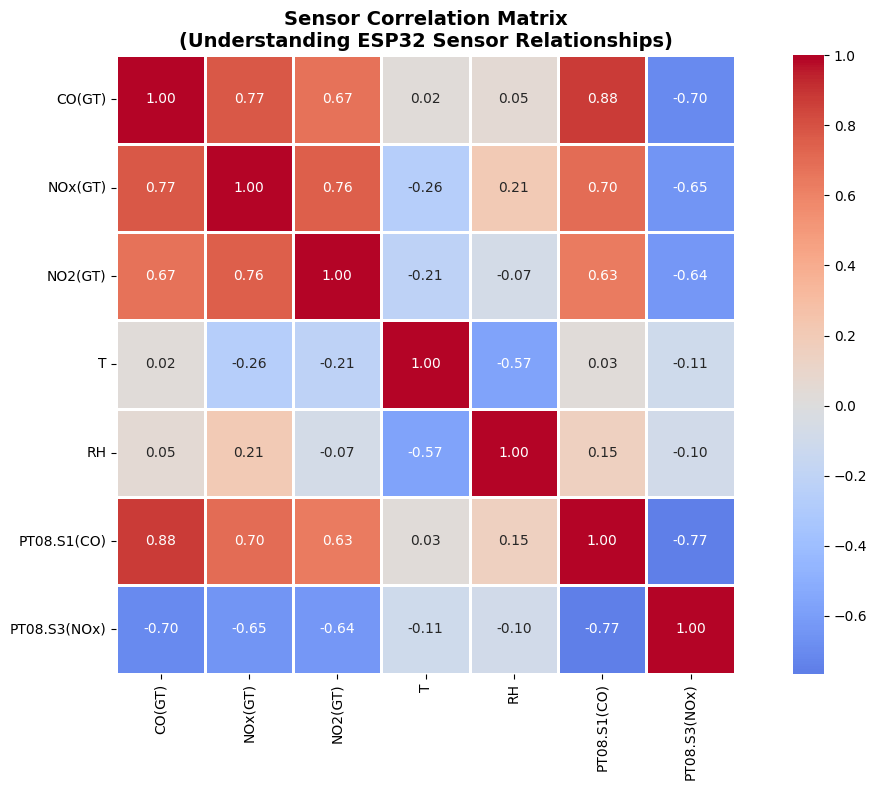

In [17]:
print("\n" + "="*70)
print("📊 VISUALIZATION 2: Sensor Correlation Heatmap")
print("="*70)

plt.figure(figsize=(12, 8))
correlation_matrix = df_model[selected_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=1)
plt.title('Sensor Correlation Matrix\n(Understanding ESP32 Sensor Relationships)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
print("\n" + "="*70)
print("📊 VISUALIZATION 3: CO vs Temperature (ESP32 Sensors)")
print("="*70)

fig = px.scatter(df_model, x='T', y='CO(GT)', color='AQI_Label',
                 title='CO Concentration vs Temperature (MQ-135 & DHT22 Simulation)',
                 labels={'T': 'Temperature (°C) - DHT22',
                         'CO(GT)': 'CO Concentration (mg/m³) - MQ-135'},
                 color_discrete_map={
                     'Good': '#00FF00',
                     'Satisfactory': '#90EE90',
                     'Moderate': '#FFFF00',
                     'Poor': '#FFA500',
                     'Very Poor': '#FF4500',
                     'Severe': '#FF0000'
                 })
fig.update_traces(marker=dict(size=5, opacity=0.6))
fig.show()


📊 VISUALIZATION 3: CO vs Temperature (ESP32 Sensors)


In [19]:
print("\n" + "="*70)
print("📊 VISUALIZATION 4: Humidity Impact on Air Quality")
print("="*70)

fig = px.box(df_model, x='AQI_Label', y='RH', color='AQI_Label',
             title='Humidity Distribution by Air Quality Category (DHT22)',
             labels={'RH': 'Relative Humidity (%) - DHT22',
                     'AQI_Label': 'Air Quality Category'},
             color_discrete_map={
                 'Good': '#00FF00',
                 'Satisfactory': '#90EE90',
                 'Moderate': '#FFFF00',
                 'Poor': '#FFA500',
                 'Very Poor': '#FF4500',
                 'Severe': '#FF0000'
             })
fig.show()


📊 VISUALIZATION 4: Humidity Impact on Air Quality


In [20]:
print("\n" + "="*70)
print("📊 VISUALIZATION 5: Pollutant Trends Over Time")
print("="*70)

# Take sample of data for cleaner visualization
sample_data = df_model.iloc[0:500]

fig = make_subplots(rows=3, cols=1,
                    subplot_titles=('CO Concentration (MQ-135)',
                                    'Temperature (DHT22)',
                                    'Humidity (DHT22)'))

fig.add_trace(go.Scatter(y=sample_data['CO(GT)'], mode='lines',
                         name='CO', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(y=sample_data['T'], mode='lines',
                         name='Temperature', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(y=sample_data['RH'], mode='lines',
                         name='Humidity', line=dict(color='blue')), row=3, col=1)

fig.update_layout(height=800, title_text="Sensor Readings Over Time (ESP32 Simulation)")
fig.show()


📊 VISUALIZATION 5: Pollutant Trends Over Time


In [21]:
print("\n" + "="*70)
print("🎯 PREPARING DATA FOR MODEL TRAINING")
print("="*70)

# Features (X) and Target (y)
X = df_model[selected_features]
y = df_model['AQI_Category']

print(f"📊 Feature matrix shape: {X.shape}")
print(f"📊 Target vector shape: {y.shape}")

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Testing set: {X_test.shape[0]} samples")

# Feature Scaling (important for sensor data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")


🎯 PREPARING DATA FOR MODEL TRAINING
📊 Feature matrix shape: (7344, 7)
📊 Target vector shape: (7344,)
✓ Training set: 5875 samples
✓ Testing set: 1469 samples
✓ Features scaled using StandardScaler


In [22]:
print("\n" + "="*70)
print("🤖 TRAINING MACHINE LEARNING MODELS")
print("="*70)

# Model 1: Random Forest (Best for IoT sensor data)
print("\n1️⃣ Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
print("✓ Random Forest trained!")

# Model 2: Gradient Boosting
print("\n2️⃣ Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
print("✓ Gradient Boosting trained!")


🤖 TRAINING MACHINE LEARNING MODELS

1️⃣ Training Random Forest Classifier...
✓ Random Forest trained!

2️⃣ Training Gradient Boosting Classifier...
✓ Gradient Boosting trained!


In [24]:
print("\n" + "="*70)
print("📈 MODEL EVALUATION")
print("="*70)

# Random Forest Predictions
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)

# Gradient Boosting Predictions
gb_predictions = gb_model.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, gb_predictions)

print("\n🎯 ACCURACY SCORES:")
print(f"  Random Forest: {rf_accuracy*100:.2f}%")
print(f"  Gradient Boosting: {gb_accuracy*100:.2f}%")

# Detailed classification report for Random Forest
print("\n" + "="*70)
print("📊 RANDOM FOREST - DETAILED CLASSIFICATION REPORT")
print("="*70)

# Get unique classes actually present in the data
unique_classes = sorted(y_test.unique())
actual_category_names = [category_names[i] for i in unique_classes]

print(f"Note: Dataset contains {len(unique_classes)} categories: {actual_category_names}\n")
print(classification_report(y_test, rf_predictions,
                          labels=unique_classes,
                          target_names=actual_category_names))


📈 MODEL EVALUATION

🎯 ACCURACY SCORES:
  Random Forest: 99.86%
  Gradient Boosting: 100.00%

📊 RANDOM FOREST - DETAILED CLASSIFICATION REPORT
Note: Dataset contains 5 categories: ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor']

              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       839
Satisfactory       1.00      1.00      1.00       480
    Moderate       0.99      1.00      1.00       123
        Poor       0.96      0.96      0.96        26
   Very Poor       0.00      0.00      0.00         1

    accuracy                           1.00      1469
   macro avg       0.79      0.79      0.79      1469
weighted avg       1.00      1.00      1.00      1469




📊 VISUALIZATION 6: Confusion Matrix


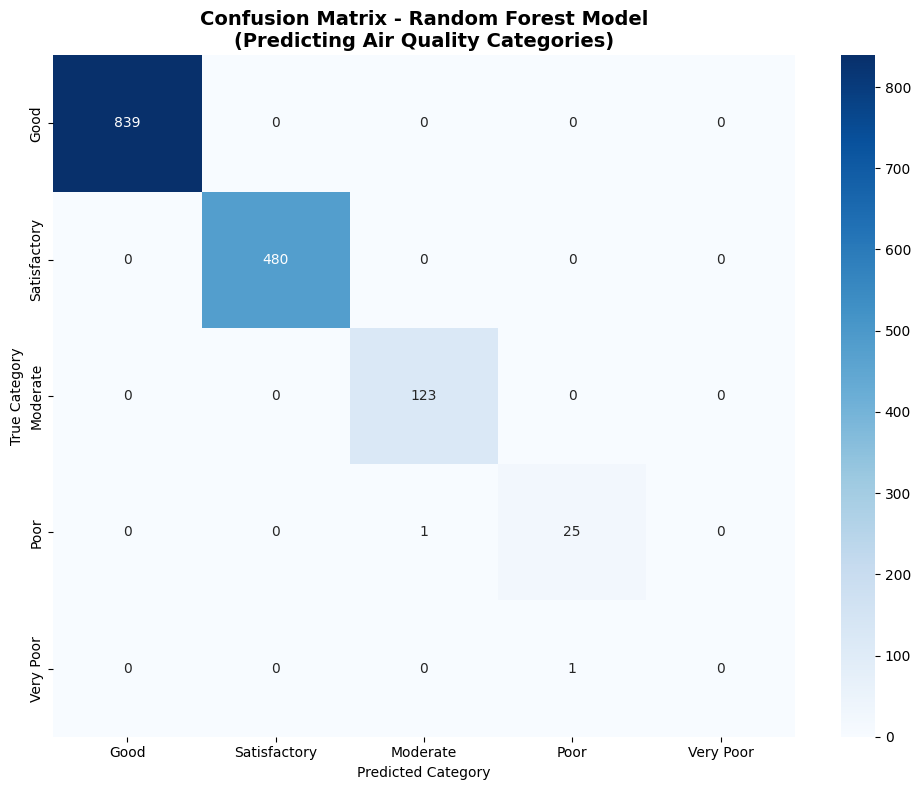

In [25]:
print("\n" + "="*70)
print("📊 VISUALIZATION 6: Confusion Matrix")
print("="*70)

# Get unique classes present
unique_classes = sorted(y_test.unique())
actual_category_names = [category_names[i] for i in unique_classes]

cm = confusion_matrix(y_test, rf_predictions, labels=unique_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=actual_category_names,
            yticklabels=actual_category_names)
plt.title('Confusion Matrix - Random Forest Model\n(Predicting Air Quality Categories)',
          fontsize=14, fontweight='bold')
plt.ylabel('True Category')
plt.xlabel('Predicted Category')
plt.tight_layout()
plt.show()

In [26]:
print("\n" + "="*70)
print("📊 VISUALIZATION 7: Feature Importance (ESP32 Sensors)")
print("="*70)

feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance)

fig = px.bar(feature_importance, x='Importance', y='Feature',
             orientation='h',
             title='Feature Importance for AQI Prediction<br>(Which ESP32 Sensors Matter Most?)',
             color='Importance',
             color_continuous_scale='Viridis')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


📊 VISUALIZATION 7: Feature Importance (ESP32 Sensors)

Feature Importance Ranking:
        Feature  Importance
0        CO(GT)    0.628275
5   PT08.S1(CO)    0.167813
6  PT08.S3(NOx)    0.085028
2       NO2(GT)    0.054347
1       NOx(GT)    0.045926
3             T    0.010585
4            RH    0.008026


In [27]:
print("\n" + "="*70)
print("🧪 TESTING MODEL WITH SAMPLE ESP32 SENSOR VALUES")
print("="*70)

# Simulate ESP32 sensor readings
test_scenarios = [
    {
        'name': 'Good Air Quality',
        'CO(GT)': 1.5,
        'NOx(GT)': 150,
        'NO2(GT)': 80,
        'T': 22.0,
        'RH': 45.0,
        'PT08.S1(CO)': 1000,
        'PT08.S3(NOx)': 800
    },
    {
        'name': 'Moderate Air Quality',
        'CO(GT)': 5.0,
        'NOx(GT)': 350,
        'NO2(GT)': 150,
        'T': 25.0,
        'RH': 60.0,
        'PT08.S1(CO)': 1400,
        'PT08.S3(NOx)': 1200
    },
    {
        'name': 'Poor Air Quality',
        'CO(GT)': 9.0,
        'NOx(GT)': 550,
        'NO2(GT)': 250,
        'T': 28.0,
        'RH': 70.0,
        'PT08.S1(CO)': 1800,
        'PT08.S3(NOx)': 1600
    }
]

print("\n🔬 Prediction Results:")
print("="*70)

for scenario in test_scenarios:
    name = scenario.pop('name')
    test_input = pd.DataFrame([scenario])
    test_input_scaled = scaler.transform(test_input)

    prediction = rf_model.predict(test_input_scaled)[0]
    prediction_proba = rf_model.predict_proba(test_input_scaled)[0]

    print(f"\n{name}:")
    print(f"  Input: CO={scenario['CO(GT)']} mg/m³, T={scenario['T']}°C, RH={scenario['RH']}%")
    print(f"  ✓ Predicted Category: {category_names[prediction]}")
    print(f"  ✓ Confidence: {prediction_proba[prediction]*100:.1f}%")


🧪 TESTING MODEL WITH SAMPLE ESP32 SENSOR VALUES

🔬 Prediction Results:

Good Air Quality:
  Input: CO=1.5 mg/m³, T=22.0°C, RH=45.0%
  ✓ Predicted Category: Good
  ✓ Confidence: 100.0%

Moderate Air Quality:
  Input: CO=5.0 mg/m³, T=25.0°C, RH=60.0%
  ✓ Predicted Category: Moderate
  ✓ Confidence: 84.0%

Poor Air Quality:
  Input: CO=9.0 mg/m³, T=28.0°C, RH=70.0%
  ✓ Predicted Category: Poor
  ✓ Confidence: 67.0%


In [28]:
print("\n" + "="*70)
print("💾 SAVING MODEL FOR ESP32 DEPLOYMENT")
print("="*70)

# Save the model
joblib.dump(rf_model, 'air_quality_rf_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

print("✓ Model saved as: air_quality_rf_model.pkl")
print("✓ Scaler saved as: feature_scaler.pkl")

# Save feature names
with open('feature_names.txt', 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")
print("✓ Feature names saved as: feature_names.txt")


💾 SAVING MODEL FOR ESP32 DEPLOYMENT
✓ Model saved as: air_quality_rf_model.pkl
✓ Scaler saved as: feature_scaler.pkl
✓ Feature names saved as: feature_names.txt
